In [6]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from typing import Callable

In [8]:
# Define some types

Func= Callable[..., np.float64]

# Monte Carlo Integration

$$
I(f) = \int_{\Omega} f(x) \, dx, \quad x\in\mathbb{R}^d
$$

## Numerical Integration

Any numerical integration method (including Monte Carlo Method) can be written in the following form:

$$
I_N(f) \approx \sum_{i=1}^N A_i f(x_i)
$$

In [19]:
# quads = (points, weights)
# shape: ((N,d), (N,))
def integrate_test(f: Func, quads: tuple[np.ndarray, np.ndarray]):
    points, weights = quads
    assert points.shape[0] == weights.shape[0]
    
    num_points = points.shape[0]
    integration = 0.0 
    for i in range(num_points):
        integration += weights[i] * f(points[i])

    return integration

In [79]:
# quads = (points, weights)
# shape: ((N,d), (N,))
def integrate(f: Func, quads: tuple[np.ndarray, np.ndarray]):
    points, weights = quads
    if isinstance(weights, np.ndarray):
        assert points.shape[0] == weights.shape[0]
    # weights: (N,)
    # f(points): (N,)
    integration = np.sum(weights * f(points))
    return integration

### Example 1

$$
\int_0^{\frac{\pi}{2}} \sin x\, dx = 1,
$$

## Determinastic Methods

Trapezoidal formula (复合梯形法)

$$
I(f) \approx \{\frac{1}{2}f(x_1) + \sum_{i=2}^{N-1} f(x_i) + \frac{1}{2}f(x_N)\} \times h
$$

In [252]:
def f1(x: np.ndarray):
    return np.sin(x)

In [40]:
N = 10000
h = 0.5 * np.pi / (N-1)
points = np.linspace(0, 0.5 * np.pi, N)
weights = np.ones((N)) * h 
weights[0] = weights[-1] = 0.5 * h

In [41]:
%timeit I1 = integrate_test(f1, (points, weights))

21.2 ms ± 460 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [110]:
I2 = integrate(f1, (points, weights))

In [111]:
I2

0.9999785377599664

In [29]:
errs = []

for h in [0.5, 0.25, 0.1, 0.05, 0.02, 0.01]:
    N = int(0.5 * np.pi / h) + 1
    points = np.linspace(0, 0.5 * np.pi, N)
    weights = np.ones((N)) * h 
    weights[0] = weights[-1] = 0.5 * h
    I = integrate_test(f1, (points, weights))
    errs.append(np.abs(I - 1.0))

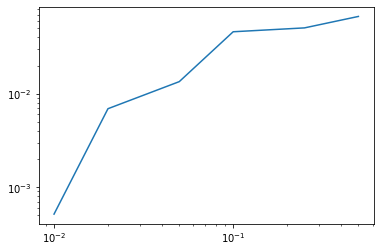

In [32]:
plt.loglog([0.5, 0.25, 0.1, 0.05, 0.02, 0.01], errs)

### Gauss

In [259]:
N = 15
a, b = 0.0, np.pi/2
points, weights = np.polynomial.legendre.leggauss(N)
points = 0.5*(points + 1)*(b - a) + a
weights = weights * 0.5 * (b - a)

In [260]:
Gauss_I = integrate(f1, (points, weights))

In [261]:
Gauss_I

0.9999999999999993

### Stochastic Method (Monte Carlo)

$$
I_N(f) \approx \frac{\pi}{2N}\sum_{i=1}^N f(X_i), \quad X_i  \mathcal{U}[0,\pi/2]
$$

$$
X_{n+1} = a X_{n} + b (\text{mod } m)
$$

In [146]:
# seed X_0
rng = np.random.default_rng(0)

In [164]:
# 向量化生成随机数
rng.uniform(0.0, np.pi/2)

1.0005370787536199

In [106]:
# seed
# rng = np.random.default_rng(1)

N = 10000
# sample points
rpoints = rng.uniform(0.0, np.pi/2, N)
weights = np.pi/2/ N

MC_I = integrate(f1, (rpoints, weights))

In [118]:
np.linspace(100, 100000, 20)

array([   100.        ,   5357.89473684,  10615.78947368,  15873.68421053,
        21131.57894737,  26389.47368421,  31647.36842105,  36905.26315789,
        42163.15789474,  47421.05263158,  52678.94736842,  57936.84210526,
        63194.73684211,  68452.63157895,  73710.52631579,  78968.42105263,
        84226.31578947,  89484.21052632,  94742.10526316, 100000.        ])

In [142]:
mc_errs = []
ns = []
for n in np.linspace(100, 100000, 20):
    int_n = int(n)
    ns.append(int_n)
    rpoints = rng.uniform(0.0, np.pi/2, int_n)
    weights = np.pi/2/n
    MC_I = integrate(f1, (rpoints, weights))
    mc_errs.append(np.abs(MC_I - 1.0))
    

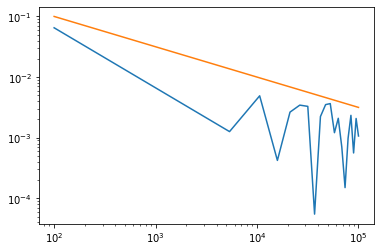

In [144]:
plt.loglog(ns, mc_errs, ns, 1.0 / np.sqrt(np.asarray(ns)))

### Example 2

$$
x, y \in [-1, 1]
$$

$$
f(x, y) = 1, \quad \text{if } x^2 + y^2 < 1
$$

$$
\int_{[0, 1]^2} f(x, y) \, dxdy
$$

In [195]:
# z: (2, N)
def f2(z):
    x = z[0]
    y = z[1]
    
    return (x**2 + y**2 < 1) * 1.0
    

In [206]:
x = np.linspace(-1.0, 1.0, 100)
y = np.linspace(-1.0, 1.0, 100)
z = np.meshgrid(x, y)

In [203]:
Z = f2(np.asarray(z))

In [204]:
Z.shape

(100, 100)

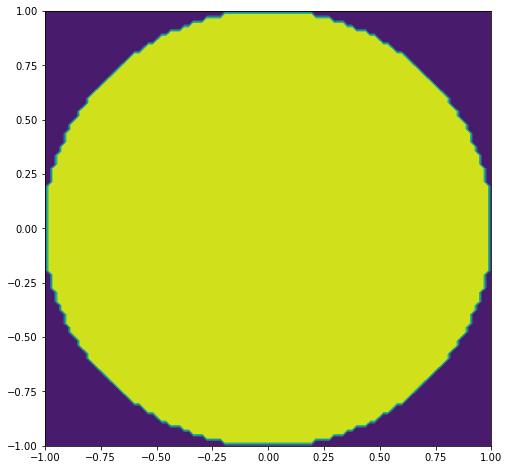

In [251]:
X, Y = z
fig, ax = plt.subplots(figsize=(8,8))
ax.contourf(X, Y, Z)

### Monte Carlo

In [213]:
# seed
rng = np.random.default_rng(1)

In [227]:
N = 10000000
# sample points
rpoints = rng.uniform(-1.0, 1.0, (2, N))
weights = 4.0 / N

MC_I_2d = integrate(f2, (rpoints, weights))

In [228]:
MC_I_2d

3.141506799999999

### 中矩形公式

In [246]:
nx = ny = 1000
h = 2.0 / nx
x = np.arange(-1.0 + 0.5*h, 1.0, h)
y = np.arange(-1.0 + 0.5*h, 1.0, h)
# (2, N=nx*xy)
xy = np.asarray(np.meshgrid(x, y))
points = xy.reshape(2, -1)
weights = h**2

In [249]:
I3 = integrate(f2, (points, weights))

In [250]:
I3

3.141824

### Example 3

$$
\int_{[0, 1]^d} e^{-x} \, dx
$$